# Post-stack seismic data

In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import segyio    
import cupy as cp
from intraseismic.utils import *
from pylops.avo import PoststackLinearModelling
from pylops.utils.wavelets import ricker
from scipy.signal import filtfilt
set_seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

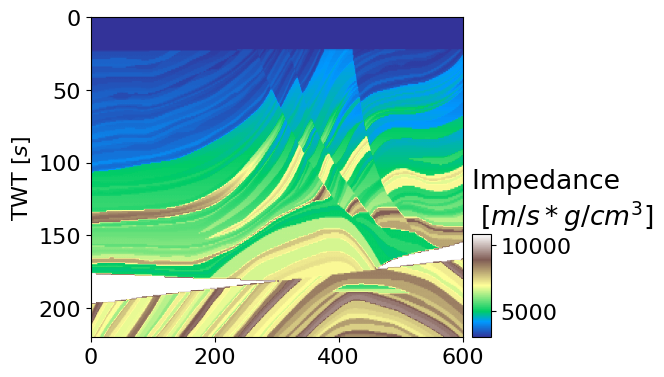

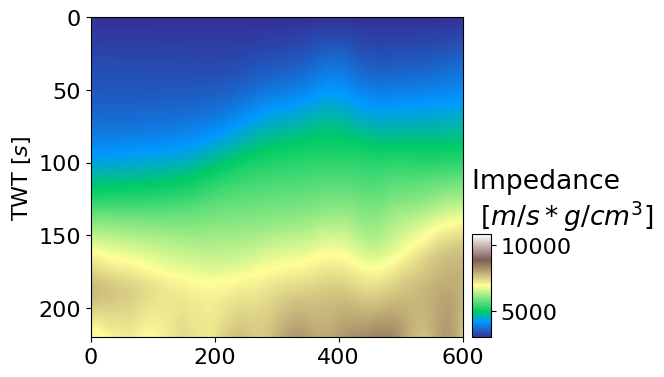

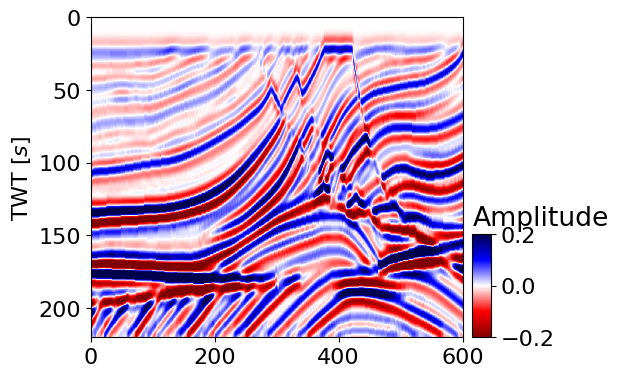

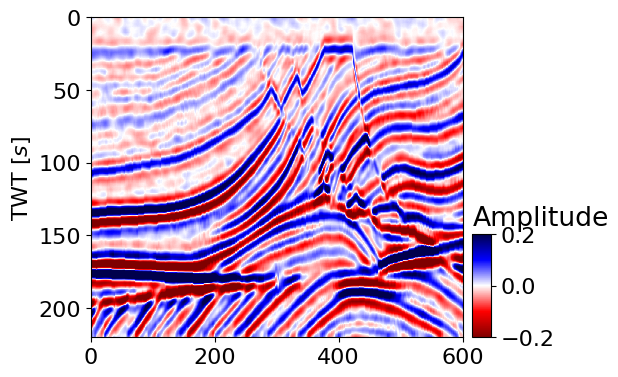

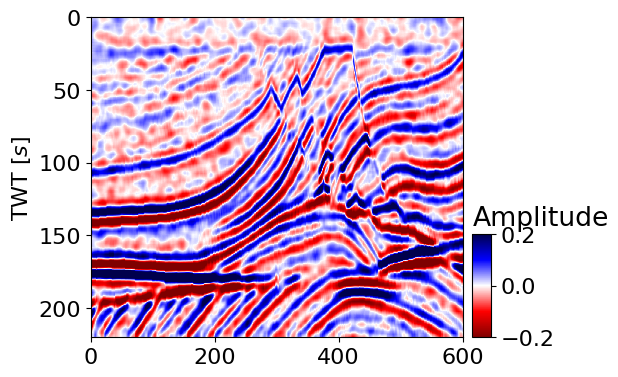

In [13]:
# Synthetic impedance model

nx = 601
nz = 221
velocity_file= '../../../Seismic_PnP/data/Marm.bin' # true model 
v =(np.fromfile(velocity_file, np.float32)
              .reshape(nz, nx))[:220, :600]

nz, nx = v.shape

den = 2.
m = np.log(v*1000 * den) #m/s*g/cm3
nsmoothz, nsmoothx = 60, 50
mback = filtfilt(np.ones(nsmoothz) / float(nsmoothz), 1, m, axis=0)
mback = filtfilt(np.ones(nsmoothx) / float(nsmoothx), 1, mback, axis=1)

# Seismic Modeling
nt0 = 301
dt0 = 0.004
t0 = np.arange(nt0) * dt0

ntwav = 61
wav, twav, wavc = ricker(t0[: ntwav // 2 + 1], 15)

# Post-Stack operator
G = PoststackLinearModelling(wav / 2, nt0=nz, spatdims=nx)

# synthetic noise-free seismic
d = G(m)

# synthetic seismic with colored noise
sigman = 1e-1  
n = filtfilt(np.ones(10)/10, 1,
             filtfilt(np.ones(5)/5, 1, np.random.normal(0, sigman, (nz, nx)).T, method='gust').T,
             method='gust')
dn1 = d + n


sigman = 2e-1  
n2 = filtfilt(np.ones(10)/10, 1,
             filtfilt(np.ones(5)/5, 1, np.random.normal(0, sigman, (nz, nx)).T, method='gust').T,
             method='gust')
dn2 = d + n2


vmin, vmax = np.percentile(np.exp(m), [3, 97])
plotmodel(np.exp(m), vmin, vmax)
plt.savefig('marm', bbox_inches='tight', transparent=True)
plotmodel(np.exp(mback), vmin, vmax)
plotdata(d)
plotdata(dn1)
plotdata(dn2)

In [11]:
# np.savez('../../data/Marmousi', m_true=np.exp(m), mback=np.exp(mback), wav=wav, d=d, dn1=dn1, dn2=dn2)

# Pre-stack seismic data

In [3]:
vp = segyio.open('../../data/MODEL_P-WAVE_VELOCITY_1.25m.segy',ignore_geometry=True)
vp = segyio.collect(vp.trace[:]).T
vpvmin, vpvmax =  np.percentile(vp, [1,99])
vp = vp[1000:, 4000:6500][::3,::3][:300, ::6]

vs = segyio.open('../../data/MODEL_S-WAVE_VELOCITY_1.25m.segy',ignore_geometry=True)
vs = segyio.collect(vs.trace[:]).T
vsvmin, vsvmax =  np.percentile(vs, [1,99])
vs = vs[1000:, 4000:6500][::3,::3][:300, ::6]

rho = segyio.open('../../data/MODEL_DENSITY_1.25m.segy',ignore_geometry=True)
rho = segyio.collect(rho.trace[:]).T * 1000  # kg/m3
rhovmin, rhovmax =  np.percentile(rho, [1,99])
rho = rho[1000:, 4000:6500][::3,::3][:300, ::6]  

vmins = [vpvmin, vsvmin, rhovmin ]
vmaxs = [vpvmax, vsvmax, rhovmax ]

In [6]:
# wavelet
nt0 = 301
dt0 = 0.004
t0 = np.arange(nt0) * dt0
ntwav = 41
wav = ricker(t0[: ntwav // 2 + 1], 12)[0]

nz, nx = vp.shape
m = np.log(np.stack((vp, vs, rho), axis=1))

# smooth model
nsmoothz, nsmoothx = 30, 25
mback = filtfilt(np.ones(nsmoothz) / float(nsmoothz), 1, m, axis=0)
mback = filtfilt(np.ones(nsmoothx) / float(nsmoothx), 1, mback, axis=2)

# angles
ntheta = 21
thetamin, thetamax = 0, 40
theta = np.linspace(thetamin, thetamax, ntheta)

wav_cp = cp.asarray(wav, dtype='float32')
theta_cp = cp.asarray(theta, dtype='float32')

vsvp = (np.exp(mback[:,1,:])/np.exp(mback[:,0,:]))[:, nx//2]
vsvp_cp = cp.asarray(vsvp, dtype='float32')

# lop operator
PPop = pylops.avo.prestack.PrestackLinearModelling(
    wav, theta, vsvp=vsvp, nt0=nz, spatdims=(nx,), linearization="akirich", explicit=True,
)

PPop_gpu = pylops.avo.prestack.PrestackLinearModelling(
    wav_cp, theta_cp, vsvp=vsvp_cp, nt0=nz, spatdims=(nx,), linearization="akirich", explicit=True,
)

# synthetic seismic with colored noise
sigman = 1e-1  
n = filtfilt(np.ones(5)/5, 1,
             filtfilt(np.ones(5)/5, 1, np.random.normal(0, sigman, (nz, ntheta, nx)), axis=0, method='gust'),
             axis=2, method='gust')

# data
dPP = PPop * m.swapaxes(0, 1).ravel()
dPP = dPP.reshape(ntheta, nz, nx).swapaxes(0, 1)
dPPn = dPP + n

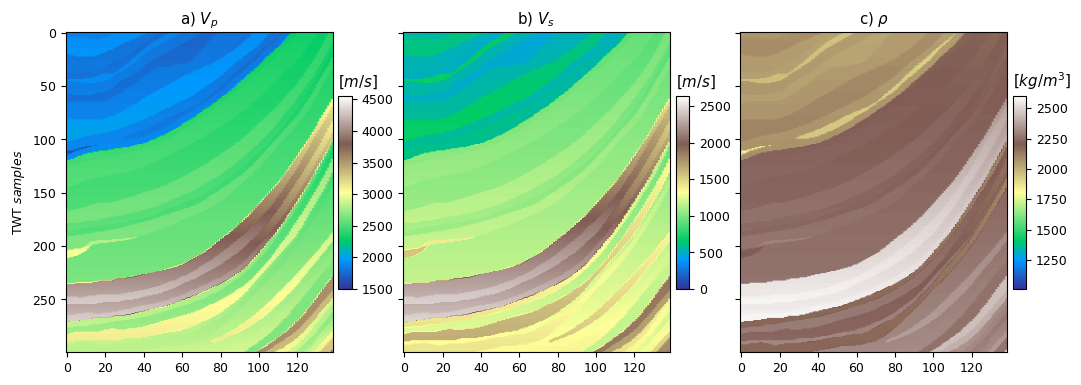

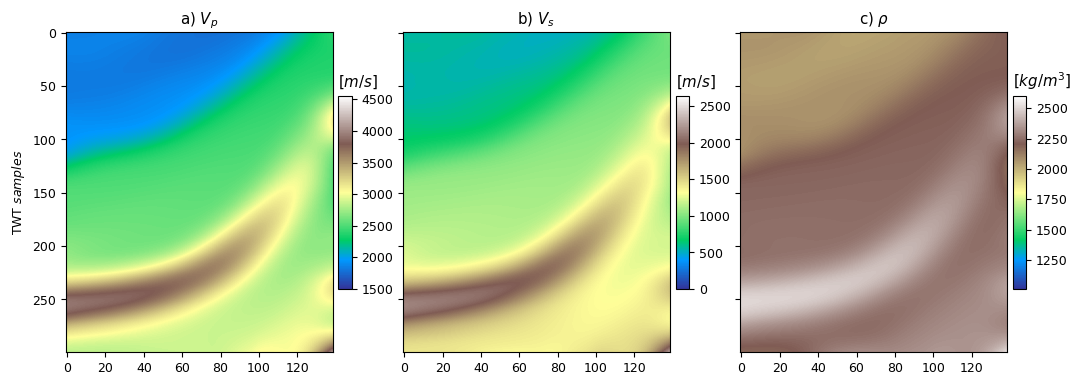

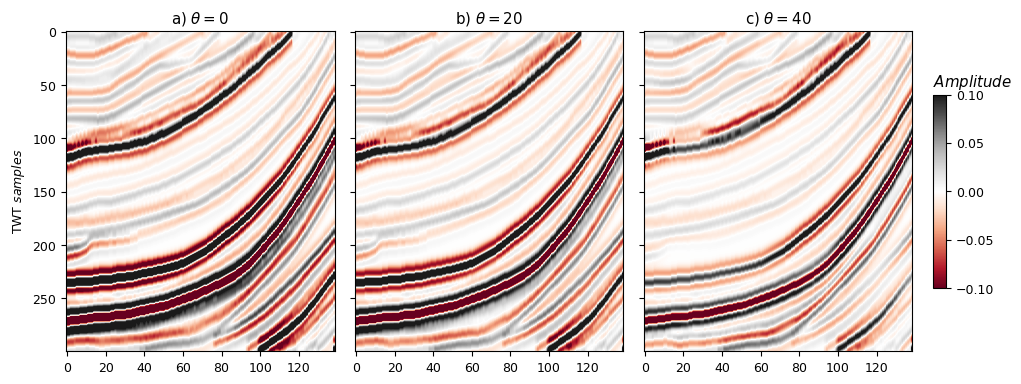

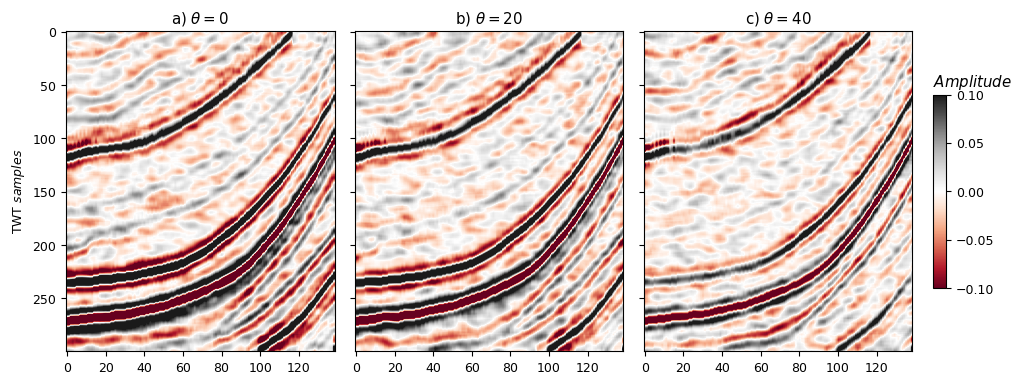

In [7]:
plt.rcParams['font.size'] = '9'
plotprestackmodel(np.exp(m), vmins, vmaxs)
plt.savefig('../plots/marm_prestack',  bbox_inches='tight', transparent=True)
plotprestackmodel(np.exp(mback), vmins, vmaxs)
plt.savefig('../plots/marm_prestack_mback',  bbox_inches='tight', transparent=True)
plotprestackdata(dPP)
plt.savefig('../plots/marm_prestack_data',  bbox_inches='tight', transparent=True)
plotprestackdata(dPPn)
plt.savefig('../plots/marm_prestack_data_noisy',  bbox_inches='tight', transparent=True)

In [11]:
# np.savez('../../data/Marmousi_prestack', 
#          m_true=np.exp(m), mback=np.exp(mback), dPP=dPP, dPPn=dPPn, 
#          wav=wav, theta=theta)